In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
#MODEL = 'gpt-3.5-turbo'
MODEL = 'gpt-4'

TEMPERATURE = 0.0
TEMPERATURE = str(TEMPERATURE).replace('.', '_')

In [4]:
df = pd.read_csv(f"responses/{MODEL}_Temperature{TEMPERATURE}.csv")
df.head()

,ID,year,test,theme,subtheme,portuguese,english,answer,responses_english,reasoning_english,responses_portuguese,reasoning_portuguese
0,1,2022,Teórica I,Anatomia,cornea,Em qual região ocular células caliciformes são...,In which ocular region are caliciform cells ph...,D,A,"Caliciform cells, also known as goblet cells, ...",A,As células caliciformes são encontradas na cór...
1,2,2022,Teórica I,Anatomia,retina,Assinale a alternativa que melhor correlaciona...,Mark the alternative that best correlates the ...,B,D,The inner nuclear layer of the retina contains...,D,As características descritas em III e IV corre...
2,3,2022,Teórica I,Anatomia,cornea,Ordene as três denominações celulares encontra...,Order the three cell names found in the cornea...,A,A,The corneal epithelium is composed of three ty...,A,As células epiteliais da córnea são organizada...
3,4,2022,Teórica I,Anatomia,cornea,"Sobre a membrana de Descemet da córnea, é corr...","Regarding Descemet's membrane of the cornea, i...",C,C,The most anterior portion of Descemet's membra...,C,A porção mais anterior da membrana de Descemet...
4,5,2022,Teórica I,Anatomia,cornea,"Sobre a camada lipídica do filme lacrimal, ass...","About the lipidic layer of the lacrimal film, ...",B,B,The lipidic layer of the lacrimal film contain...,B,A camada lipídica do filme lacrimal é secretad...


### Data Cleaning

In [5]:
def get_response(response):
    options = {'a)': 'a', 'b)':'b', 'c)': 'c', 'd)':'d'}
    
    for option in options.keys():
        if option in response:
            return options[option]
    else:
        return response

In [6]:
df['answer'] = df['answer'].str.lower()
df['responses_english'] = df['responses_english'].str.lower()
df['responses_english'] = df['responses_english'].apply(get_response)

df['responses_portuguese'] = df['responses_portuguese'].str.lower()
df['responses_portuguese'] = df['responses_portuguese'].apply(get_response)

In [7]:
pd.unique(df['theme'])

array(['Anatomia', 'Embriologia', 'Genética', 'Refração', 'Farmacologia',
       'Glaucoma', 'Retina', 'Oncologia', 'Córnea', 'Glaucoma ',
       'Glaucoma/Uveíte', 'Farmacologia/Glaucoma', 'Óptica/Refração',
       'Óptica', 'Estrabismo', 'Neuroftalmologia', 'Uveíte',
       'Retina/Oncologia', 'Plástica Ocular', 'Refração/Visão subnormal',
       'Visão subnormal', 'Cirurgia Refrativva', 'Cirurgia Refrativa',
       'Lentes de Contato', 'Oncologia/Plástica Ocular',
       'Córnea/Cristalino', 'Cristalino/Catarata'], dtype=object)

### Data Analysis

In [8]:
# Calculate the matches between 'answer' and 'responses_english' and 'responses_portuguese'
df['match_english'] = df['answer'] == df['responses_english']
df['match_portuguese'] = df['answer'] == df['responses_portuguese']
df['Total'] = True

# Group by 'test', 'year', and 'theme' and calculate the count of matches
matches_by_test = df.groupby(['test', 'year', 'theme']).agg({
    'match_english': 'sum',
    'match_portuguese': 'sum',
    'Total': 'sum'
}).reset_index()

In [8]:
# Create folder to save the plots and the csv file if it does not exist
if not os.path.exists(f'results_{MODEL}_Temperature{TEMPERATURE}'):
    os.makedirs(f'results_{MODEL}_Temperature{TEMPERATURE}')

matches_by_test.to_csv(f'results_{MODEL}_Temperature{TEMPERATURE}/matches_results_{MODEL}.csv', index=False)

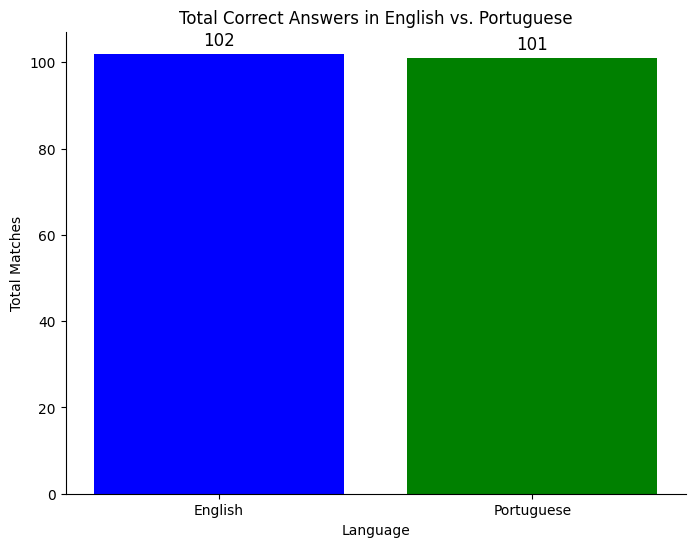

In [9]:
total_english = df['match_english'].sum()
total_portuguese = df['match_portuguese'].sum()

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the total matches
bars = ax.bar(['English', 'Portuguese'], [total_english, total_portuguese], color=['blue', 'green'])

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.xlabel('Language')
plt.ylabel('Total Matches')
plt.title('Total Correct Answers in English vs. Portuguese')

# Customize the appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/total_matches_{MODEL}.png', bbox_inches='tight')
plt.show()

In [10]:
matches_by_test_group = matches_by_test.groupby('theme').agg({
    'match_english': 'sum',
    'match_portuguese': 'sum',
    'Total': 'sum'
}).reset_index()

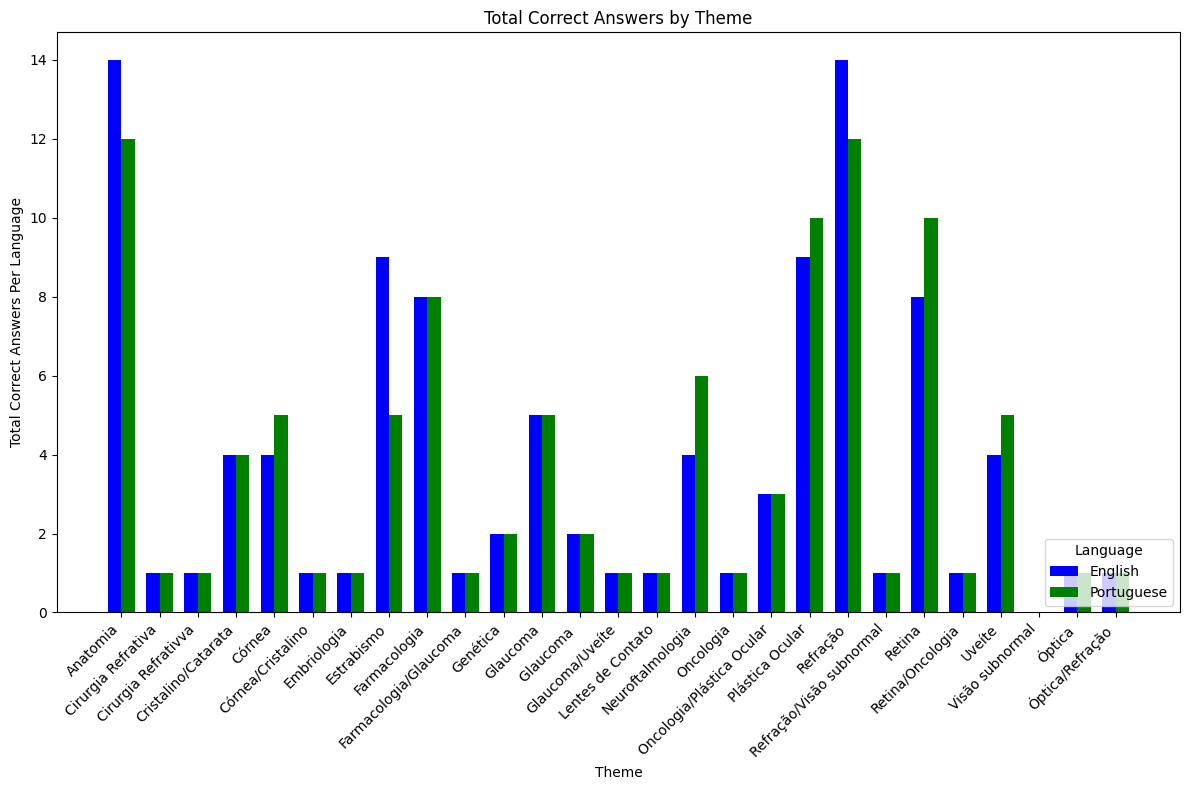

In [11]:
# Compare English and Portuguese matches by theme
fig, ax = plt.subplots(figsize=(12, 8))

# Set the bar width
bar_width = 0.35

# Calculate the positions for the bars
bar_positions_english = range(len(matches_by_test_group['theme']))
bar_positions_portuguese = [p + bar_width for p in bar_positions_english]

# Plot the English matches
ax.bar(bar_positions_english, matches_by_test_group['match_english'], color='blue', width=bar_width, label='English')

# Plot the Portuguese matches
ax.bar(bar_positions_portuguese, matches_by_test_group['match_portuguese'], color='green', width=bar_width, label='Portuguese')

# Customize the plot
ax.set_xlabel('Theme')
ax.set_ylabel('Total Correct Answers Per Language')
ax.set_title('Total Correct Answers by Theme')
ax.set_xticks([p + bar_width / 2 for p in bar_positions_english])
ax.set_xticklabels(matches_by_test_group['theme'], rotation=45, ha='right')

# Add a legend
plt.legend(title='Language', loc='lower right')

plt.tight_layout()

plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/matches_by_theme_{MODEL}.png', bbox_inches='tight')
plt.show()


      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Anatomia             14                12     21                 66.666667   

   portuguese_ratio_percentage  
0                    57.142857  


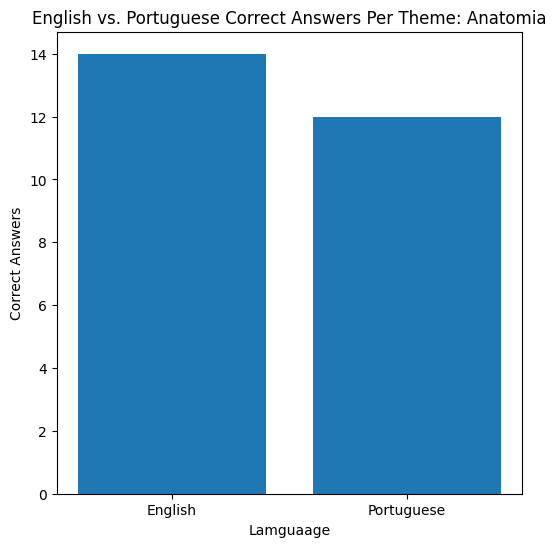

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Córnea              4                 5     10                      40.0   

   portuguese_ratio_percentage  
0                         50.0  


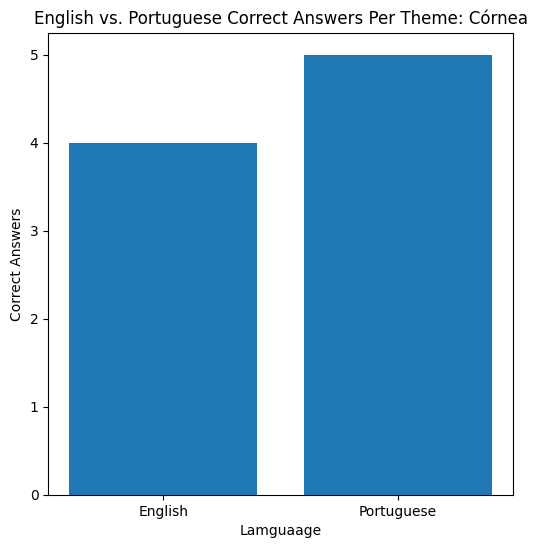

         theme  match_english  match_portuguese  Total  \
0  Embriologia              1                 1      2   

   english_ratio_percentage  portuguese_ratio_percentage  
0                      50.0                         50.0  


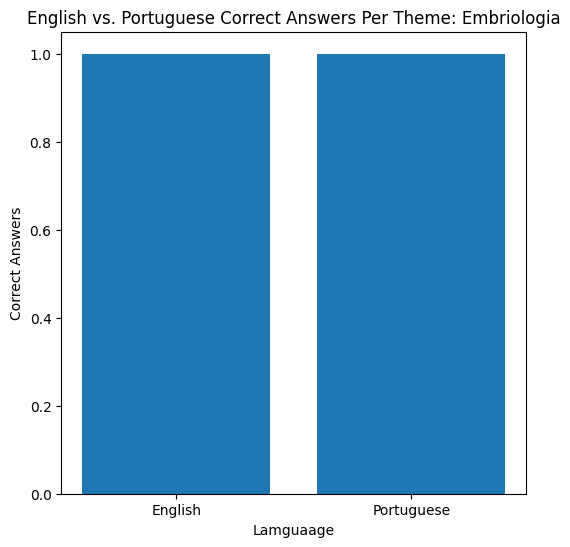

          theme  match_english  match_portuguese  Total  \
0  Farmacologia              8                 8      9   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 88.888889                    88.888889  


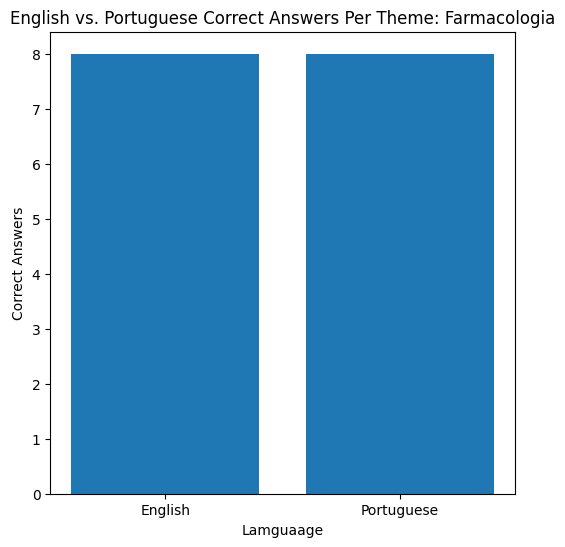

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Genética              2                 2      2                     100.0   

   portuguese_ratio_percentage  
0                        100.0  


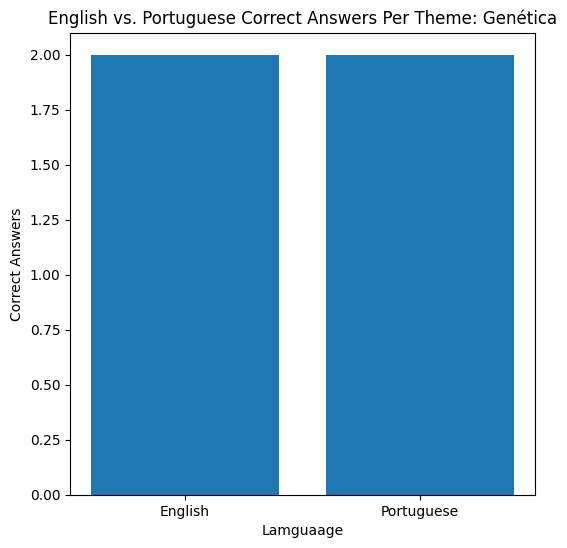

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Glaucoma              5                 5      7                 71.428571   

   portuguese_ratio_percentage  
0                    71.428571  


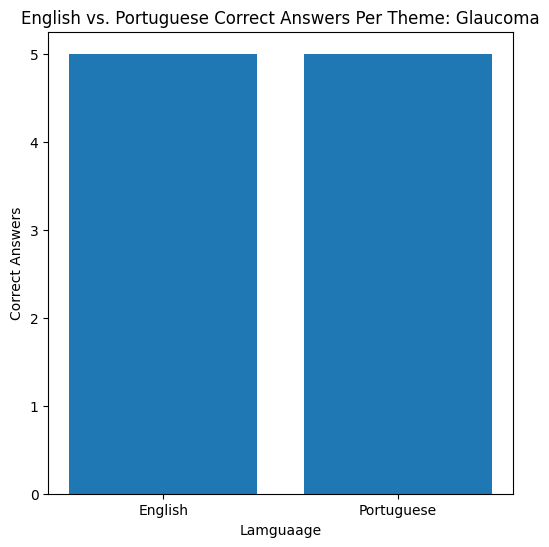

       theme  match_english  match_portuguese  Total  \
0  Oncologia              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


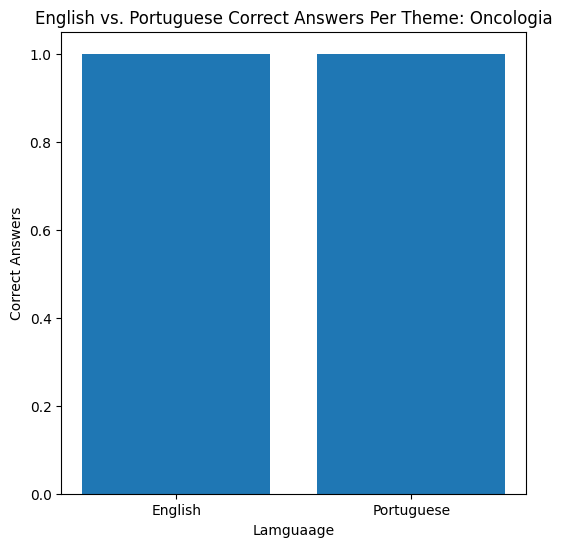

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Refração             14                12     31                  45.16129   

   portuguese_ratio_percentage  
0                    38.709677  


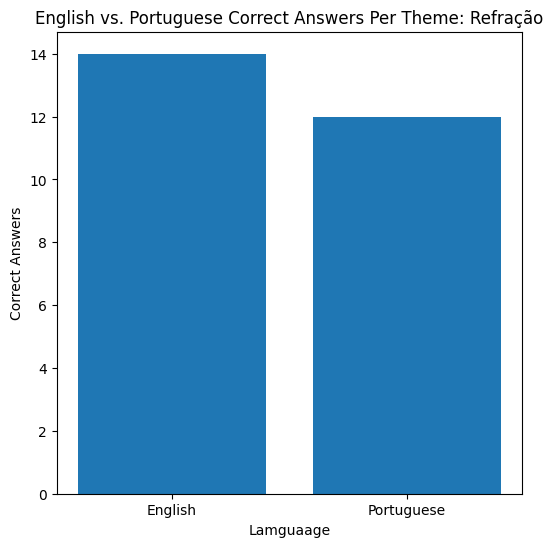

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Retina              8                10     12                 66.666667   

   portuguese_ratio_percentage  
0                    83.333333  


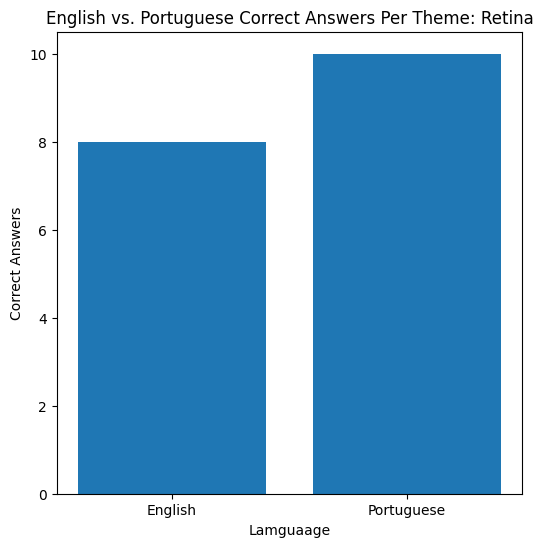

                theme  match_english  match_portuguese  Total  \
0  Cirurgia Refrativa              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


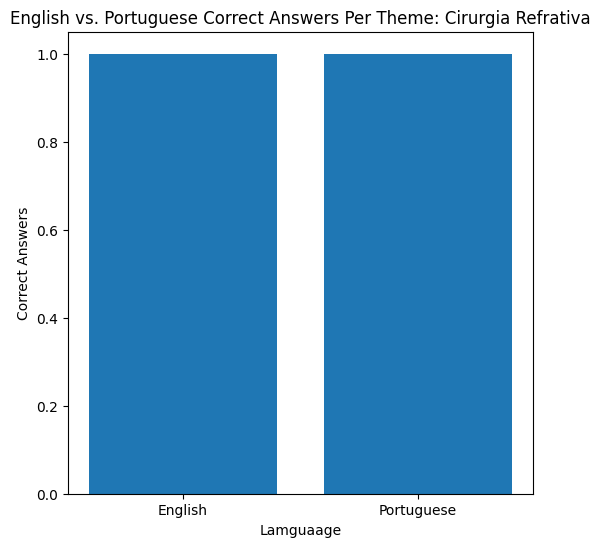

                 theme  match_english  match_portuguese  Total  \
0  Cirurgia Refrativva              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


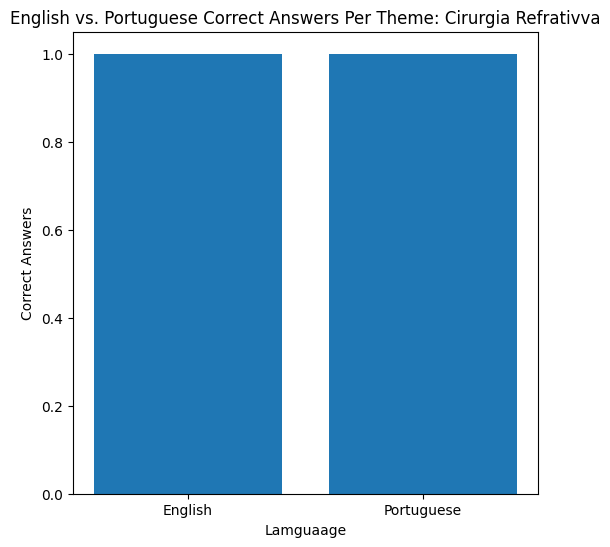

                 theme  match_english  match_portuguese  Total  \
0  Cristalino/Catarata              4                 4      8   

   english_ratio_percentage  portuguese_ratio_percentage  
0                      50.0                         50.0  


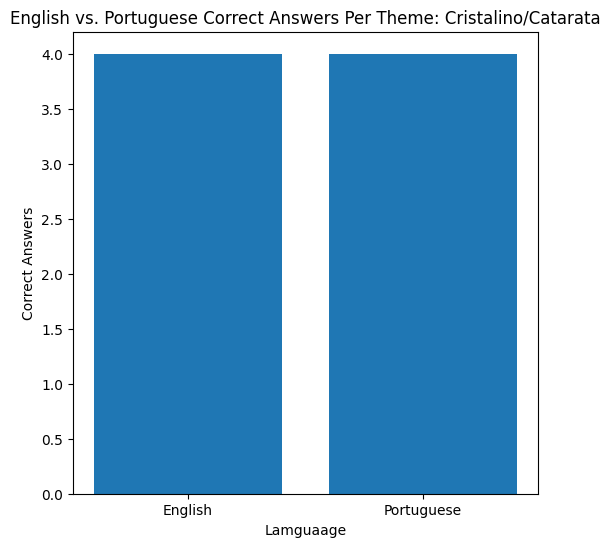

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Córnea              4                 5     10                      40.0   

   portuguese_ratio_percentage  
0                         50.0  


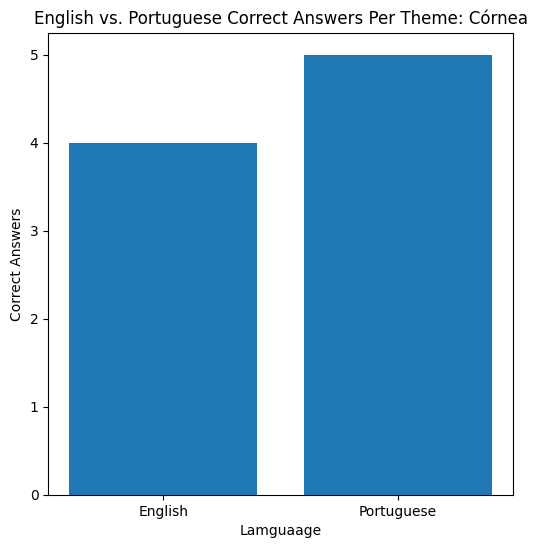

               theme  match_english  match_portuguese  Total  \
0  Córnea/Cristalino              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


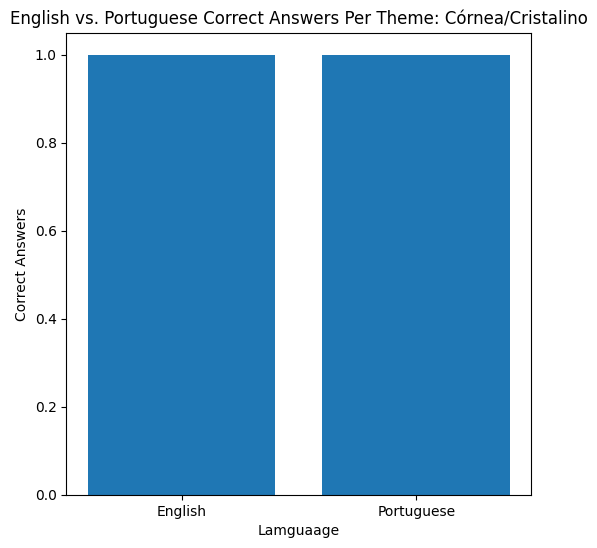

        theme  match_english  match_portuguese  Total  \
0  Estrabismo              9                 5     11   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 81.818182                    45.454545  


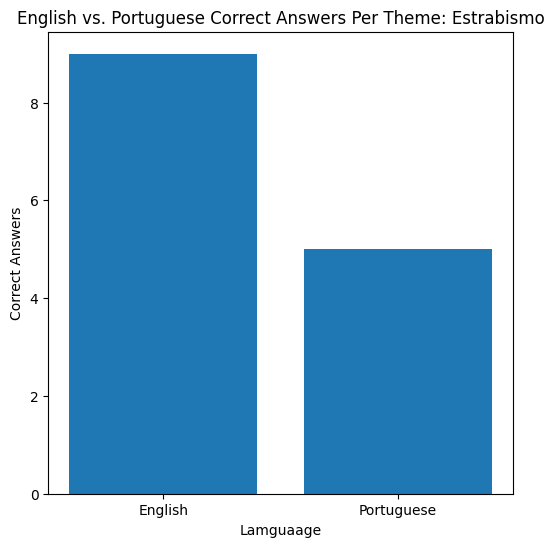

          theme  match_english  match_portuguese  Total  \
0  Farmacologia              8                 8      9   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 88.888889                    88.888889  


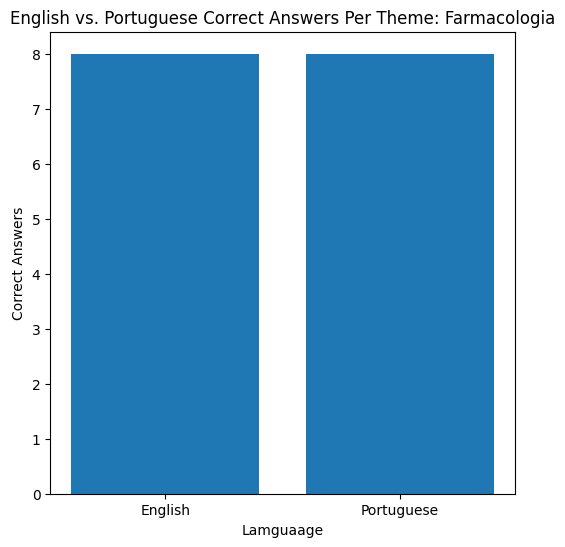

                   theme  match_english  match_portuguese  Total  \
0  Farmacologia/Glaucoma              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


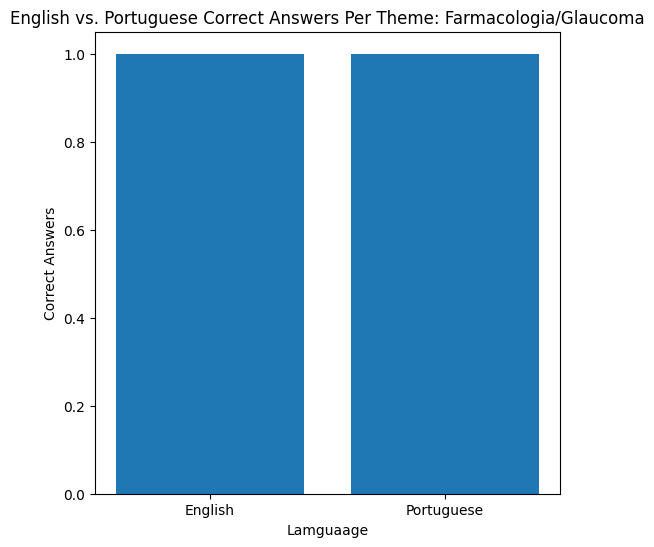

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Glaucoma              5                 5      7                 71.428571   

   portuguese_ratio_percentage  
0                    71.428571  


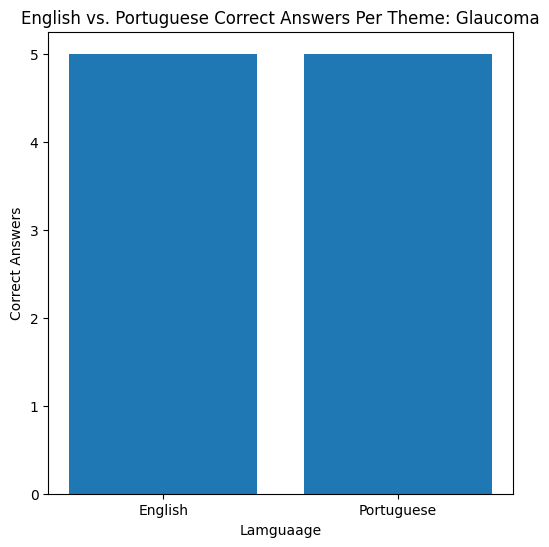

       theme  match_english  match_portuguese  Total  \
0  Glaucoma               2                 2      2   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


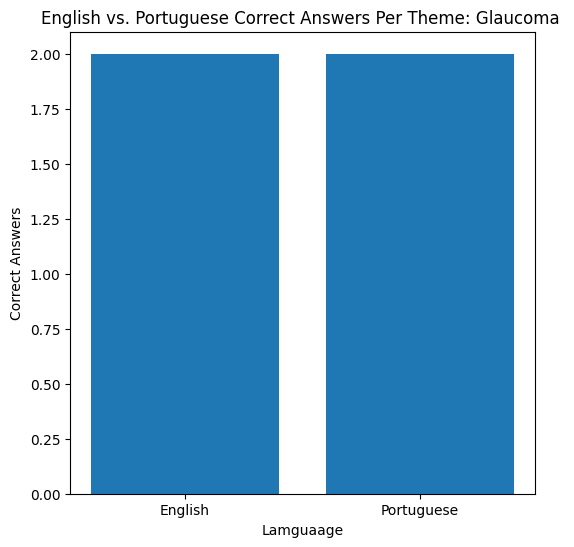

             theme  match_english  match_portuguese  Total  \
0  Glaucoma/Uveíte              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


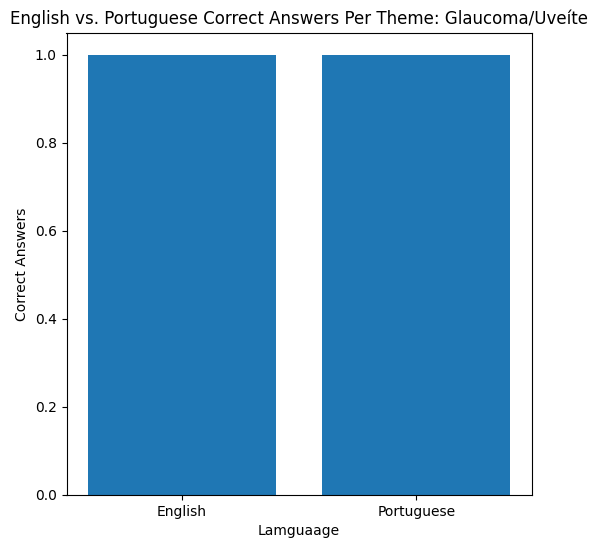

               theme  match_english  match_portuguese  Total  \
0  Lentes de Contato              1                 1      3   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 33.333333                    33.333333  


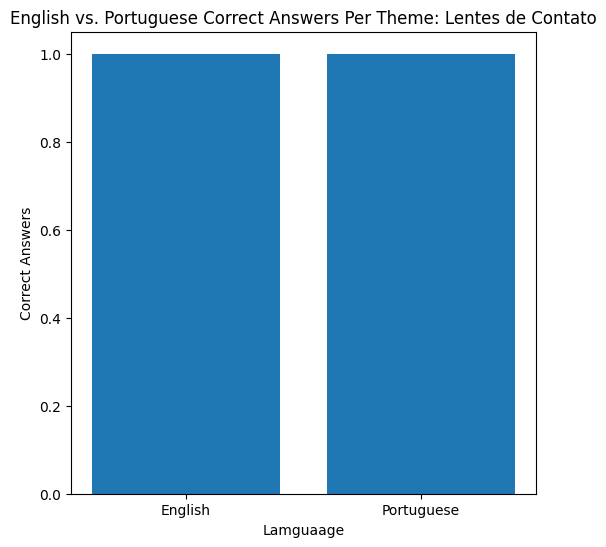

              theme  match_english  match_portuguese  Total  \
0  Neuroftalmologia              4                 6      7   

   english_ratio_percentage  portuguese_ratio_percentage  
0                 57.142857                    85.714286  


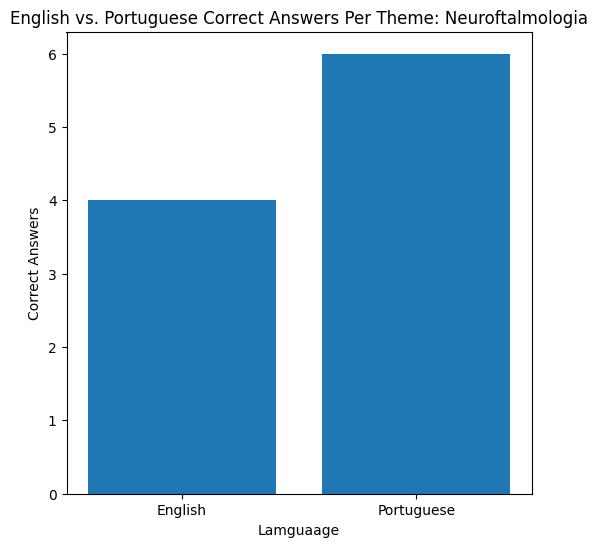

                       theme  match_english  match_portuguese  Total  \
0  Oncologia/Plástica Ocular              3                 3      3   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


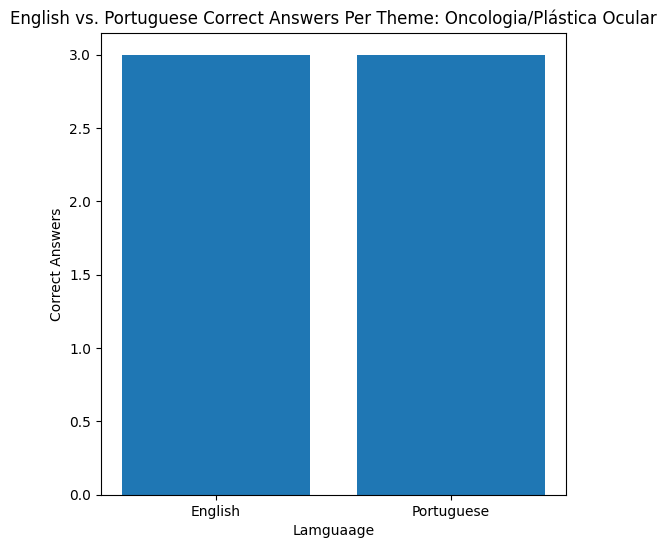

             theme  match_english  match_portuguese  Total  \
0  Plástica Ocular              9                10     16   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     56.25                         62.5  


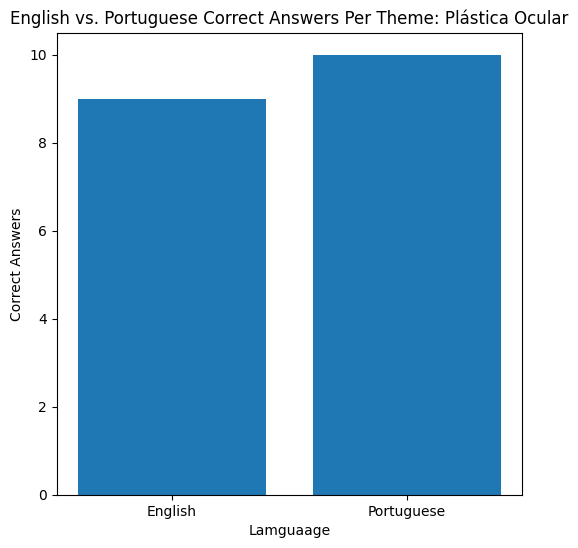

      theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Refração             14                12     31                  45.16129   

   portuguese_ratio_percentage  
0                    38.709677  


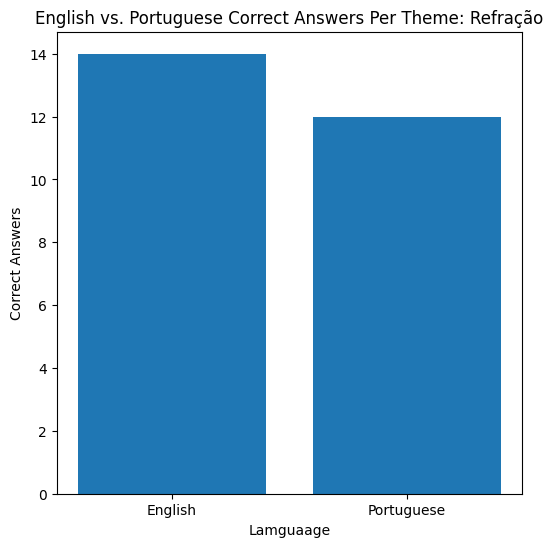

                      theme  match_english  match_portuguese  Total  \
0  Refração/Visão subnormal              1                 1      2   

   english_ratio_percentage  portuguese_ratio_percentage  
0                      50.0                         50.0  


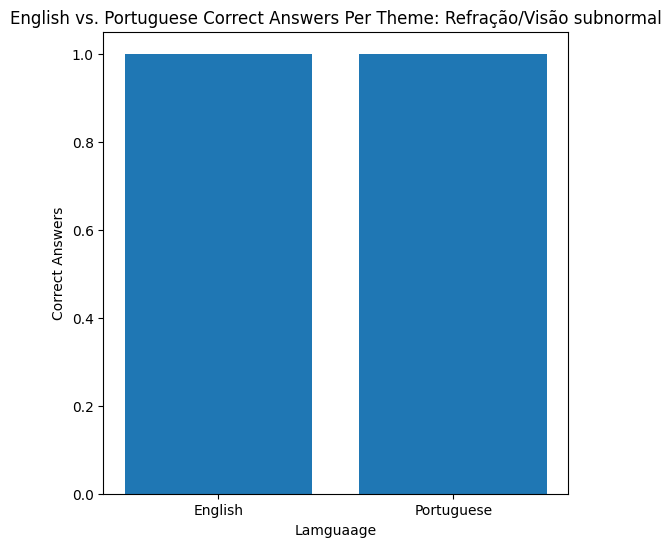

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Retina              8                10     12                 66.666667   

   portuguese_ratio_percentage  
0                    83.333333  


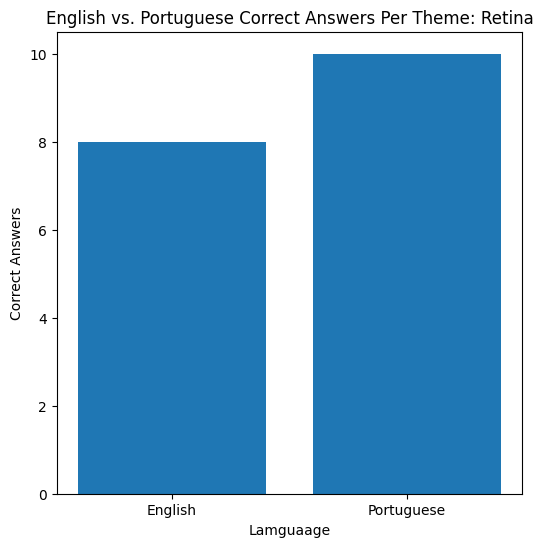

              theme  match_english  match_portuguese  Total  \
0  Retina/Oncologia              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


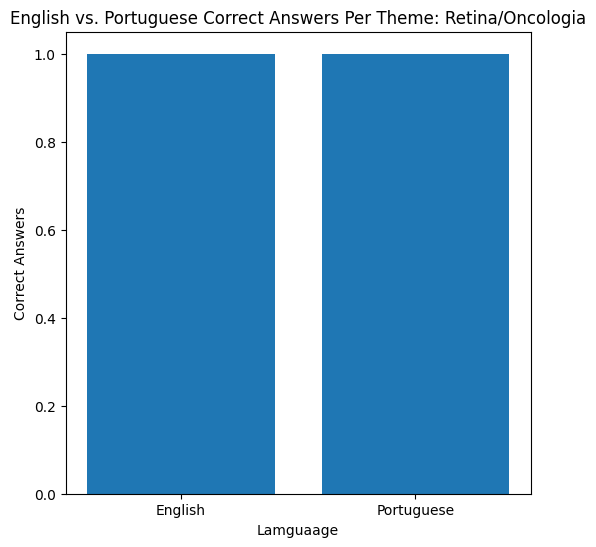

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Uveíte              4                 5      8                      50.0   

   portuguese_ratio_percentage  
0                         62.5  


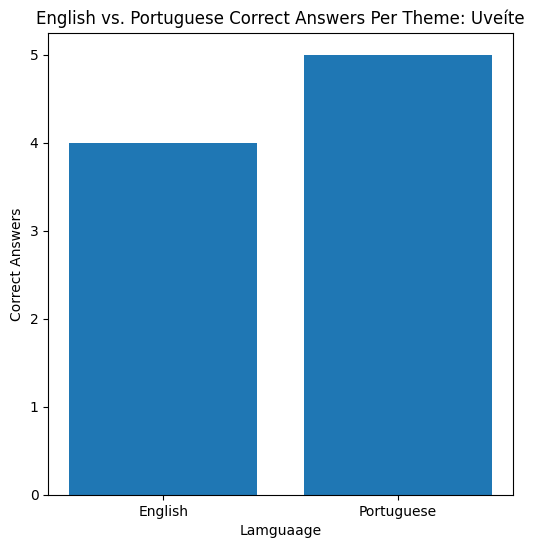

             theme  match_english  match_portuguese  Total  \
0  Visão subnormal              0                 0      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                       0.0                          0.0  


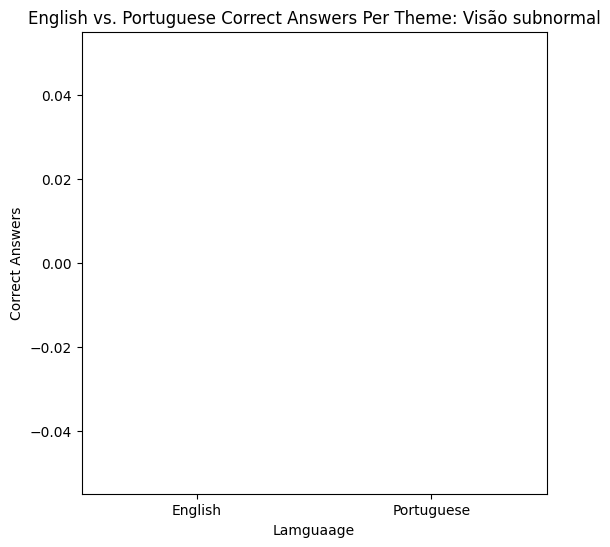

    theme  match_english  match_portuguese  Total  english_ratio_percentage  \
0  Óptica              1                 1      1                     100.0   

   portuguese_ratio_percentage  
0                        100.0  


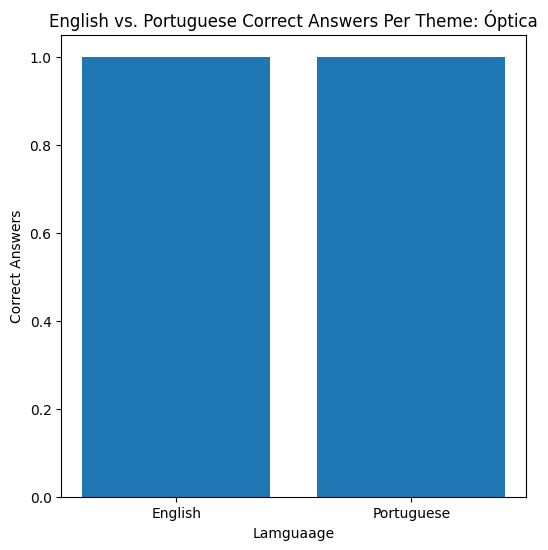

             theme  match_english  match_portuguese  Total  \
0  Óptica/Refração              1                 1      1   

   english_ratio_percentage  portuguese_ratio_percentage  
0                     100.0                        100.0  


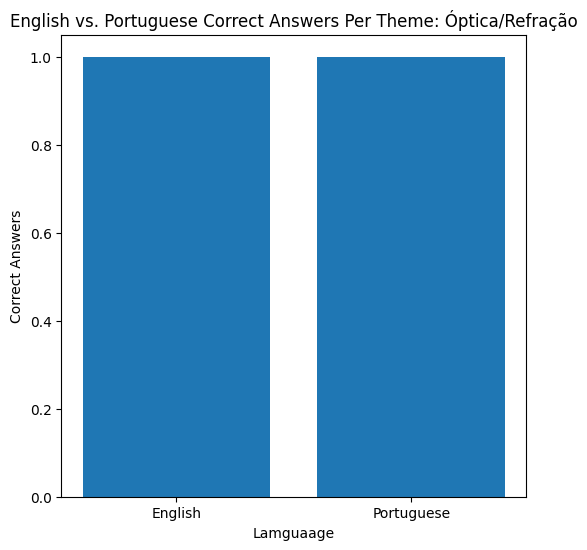

In [12]:
for theme in matches_by_test['theme']:
    df_theme = matches_by_test[matches_by_test['theme'] == theme].groupby(['theme']).agg({
                                                                    'match_english': 'sum',
                                                                    'match_portuguese': 'sum',
                                                                    'Total': 'sum'
                                                                    }).reset_index()
    
    # Calculate the ratio of matches as a percentage of the total for each language
    df_theme['english_ratio_percentage'] = (df_theme['match_english'] / df_theme['Total']) * 100
    df_theme['portuguese_ratio_percentage'] = (df_theme['match_portuguese'] / df_theme['Total']) * 100

    print(df_theme)

    # Plot the ratio of matches for each theme
    plt.figure(figsize=(6, 6))
    plt.bar(['English', 'Portuguese'], [df_theme['match_english'].sum(), df_theme['match_portuguese'].sum()])
    plt.xlabel('Lamguaage')
    plt.ylabel('Correct Answers')
    plt.title(f'English vs. Portuguese Correct Answers Per Theme: {theme}')
    
    if '/' not in theme:
        plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/correct_answers_{MODEL}_{theme}.png', bbox_inches='tight')
    else:
        plt.savefig(f'results_{MODEL}_Temperature{TEMPERATURE}/correct_answers_{MODEL}_{theme.replace("/", "-")}.png', bbox_inches='tight')
    plt.show()